# Ad-hoc LCE
#### Where toy-mc is the law but G4 is avoided like the devil.

Light collection efficiency maps are the tool which takes as input a initial position of a photon, usually assuming isotropical angular distribution, and returns the probability distribution of where the photon will end up. For standard TPCs, building LCE maps is a rather complex yet vital step to properly reconstruct the light yield of the detector and take into account its geometry particularities. Very precise geometries and optical parameters are taken as input and sim-data matching is often used to callibrate such maps. 

For the purpose of the simplistic approach in this simulation pacakge, the LCE maps to get have the same conceptual start but a much more straightforward implementation. Here, only the proportional scnitillation signal is relevant, therefore LCE maps of the whole volume are not required. Morevoer, given the focusing mesh effect and the approximation taken on that regard (see hex_mesh_model.ipynb and Main.ipynb), there are a finite number of possible positions for the electrons to start their multiplication process, which naturally leads to the approximation of the same number of positions as initial vertex of the photons.

To calculate the LCE map of each hex center position a large number of photons is simulated as straight lines and their final position on the optical plane is given by: 
$$ x' = x_0 + (z'-z_0)\cos{\varphi}\tan{\theta}\\$$
$$y' = y_0 + (z'-z_0)\sin{\varphi}\tan{\theta}$$

To save computing time, only photons with $0<\theta<\pi/2$ are simulated. The distribution on the array is then discretised normalized to the area of the 2D bin. Finally, thi distribution is smeared and an interpolation function prepared in order to have the probability values at any postion within the array area. This is done for each of the hex centres. The final signal is then the sum of the individual hex centers LCEs, scaled by the number of electrons on the corresponding centre:

$$\sum^{n_{hex}}_i\int LCE_i\left(x,y\right)dxdy$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as itp

from xenodiffusionscope import TPC, LCEPattern

### Initialise objects

In [2]:
r_max, hex_size = 75, 1.56
length = 2600
liquid_gap = 5
gas_gap = 5
drift_field = 100

In [3]:
Xenoscope = TPC(r_max, length, liquid_gap, gas_gap, drift_field)
mesh = Xenoscope.gate_mesh

In [4]:
len(mesh.hex_centers)

2787

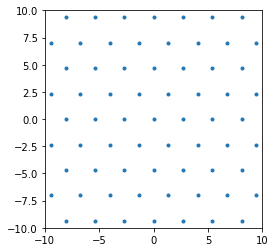

In [5]:
plt.plot(mesh.hex_centers[:,0],mesh.hex_centers[:,1], ls = '', marker = '.')
plt.ylim(-10,10)
plt.xlim(-10,10)
plt.gca().set_aspect('equal')
plt.show()

## Get the pattern on the array from one of the hex centers

We follow Physics convention: theta is inclination, phi is azimuthal and r is r.

In [6]:
def get_xy_on_plane(x0,y0,z0,directions,z_prime):
    '''
    Return the (x,y) of the intersection of a vector with direction 
    (theta,phi), physics convention, starting at point (x0,y0,z0) and
    finishing at the plane z=z_prime.
    '''
    x_prime = x0 + (z_prime-z0) * np.cos(directions[:,1]) * np.tan(directions[:,0])
    y_prime = y0 + (z_prime-z0) * np.sin(directions[:,1]) * np.tan(directions[:,0])
    
    return np.stack((x_prime, y_prime), axis = 1)

In [7]:
z_anode = 10

In [8]:
x0,y0,z0 = 0,0,0

n_traces = 100000

thetas = np.random.uniform(0,np.pi/2,n_traces)
phis = np.random.uniform(0,2*np.pi,n_traces)
directions = np.stack((thetas,phis), axis = 1)

### Run the toys

In [9]:
final_pos = get_xy_on_plane(x0,y0,z0,directions, z_anode)

In [10]:
final_pos.shape

(100000, 2)

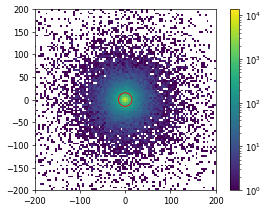

In [11]:
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
fig,ax = plt.subplots(1,1, dpi = 60)
hist2d = ax.hist2d(final_pos[:,0], final_pos[:,1],
           bins = (np.linspace(-200,200,100),np.linspace(-200,200,100)),
           cmin = 1, norm = LogNorm())#, density = True)

fig.colorbar(hist2d[3])
ax.add_patch(Circle((0,0),15,fill = False, color = 'r'))
ax.set_aspect('equal')
plt.show()

In [12]:
final_r = TPC.get_r(final_pos[:,0],final_pos[:,1])
mask_r = final_r < 15
final_pos_array = final_pos[mask_r]
print('Initial number of photons: %s'%n_traces)
print('Number of photons in array: %s (%.2f%% of produced, %.2f of full emission)'%(len(final_pos_array),
                                                                                  len(final_pos_array)/n_traces*100,
                                                                                  len(final_pos_array)/n_traces*100/2))

Initial number of photons: 100000
Number of photons in array: 62866 (62.87% of produced, 31.43 of full emission)


In [13]:
def get_ph_in_array(n_ph, x0,y0,z0,z_anode=10,r_max=30):
    thetas = np.random.uniform(0,np.pi/2,n_traces)
    phis = np.random.uniform(0,2*np.pi,n_traces)
    directions = np.stack((thetas,phis), axis = 1)
    final_pos = get_xy_on_plane(x0,y0,z0,directions, z_anode)
    final_r = TPC.get_r(final_pos[:,0],final_pos[:,1])
    mask_r = final_r < r_max
    final_pos_array = final_pos[mask_r]
    return final_pos_array

In [14]:
pos = get_ph_in_array(10000,-5,7,0)

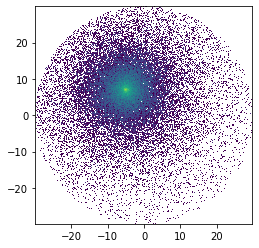

In [15]:
plt.hist2d(pos[:,0],pos[:,1], bins = 300, norm = LogNorm())
plt.gca().set_aspect('equal')
plt.show()

### Make histogram with defined bin size and map

In [16]:
x_bin_step = 1#0.1 #mm
y_bin_step = 1#0.1 #mm
x_min = y_min = -np.ceil(r_max*1.1)
x_max = y_max = np.ceil(r_max*1.1)

x_bin_sides = np.arange(x_min,x_max+x_bin_step*0.1,x_bin_step)
y_bin_sides = np.arange(y_min,y_max+x_bin_step*0.1,y_bin_step)
x_bin_middles = x_bin_sides[:-1] + x_bin_step/2
y_bin_middles = y_bin_sides[:-1] + y_bin_step/2

hist2d = np.histogram2d(pos[:,0],pos[:,1],
                        bins = (x_bin_sides,y_bin_sides),
                                density = False) 
#density could be True but we can also do it by hand given the bin area and total of photons
#It's even better because it can be normalized properly from the start taking into account 
#the photonos projected downwards and the ones that miss the array.

In [17]:
xx, yy = np.meshgrid(x_bin_middles, y_bin_middles, indexing ='ij')

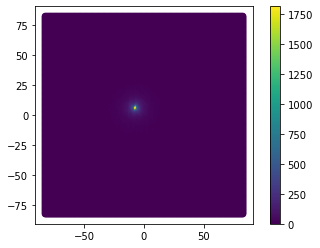

In [18]:
plt.scatter(xx,yy,c = hist2d[0])
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

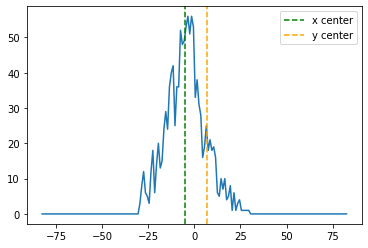

In [19]:
plt.plot(x_bin_middles,hist2d[0][:,80])
plt.axvline(-5, ls = '--', c = 'green', label ='x center')
plt.axvline(7, ls = '--', c = 'orange', label ='y center')
plt.legend()
plt.show()

### Normalise the distribution

In [20]:
#from hist2d to 2dpdf
assert np.sum(hist2d[0]) == len(pos), 'Lost some photons on the histogram??'
bin_area = x_bin_step*y_bin_step
total_in_hist = np.sum(hist2d[0])
hist_density = hist2d[0] /bin_area/(n_traces*2) #fraction/mm^2

/tmp/ipykernel_19817/2049973765.py:1: RuntimeWarning: divide by zero encountered in log
  plt.scatter(xx,yy,c = np.log(hist_density*100))


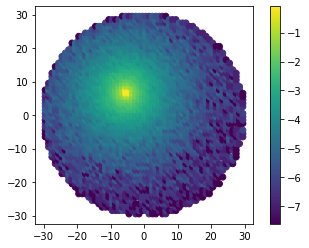

In [21]:
plt.scatter(xx,yy,c = np.log(hist_density*100))
plt.colorbar()
plt.gca().set_aspect('equal')
plt.show()

In [22]:
hist_density.shape

(166, 166)

## Define interpolation function

In [23]:
interp2s = itp.RectBivariateSpline(x_bin_middles, 
                                                 y_bin_middles,
                                                 hist_density)

In [24]:
interp2s(0,0)

array([[0.00035423]])

## Use the LCEPattern class like good coders we are not

In [25]:
def plot_pattern_reconstruction(toy_events, x_bin_middles,y_bin_middles,hist_density,pattern):
    fig, axs = plt.subplots(1,3, figsize = (10,3),dpi = 60)

    axs[0].set_title('Toy events')
    toys = axs[0].hist2d(toy_events[:,0],toy_events[:,1],cmin = 1, norm=LogNorm(), bins = 100)
    axs[0].add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    axs[0].set_aspect('equal')
    axs[0].set_xlim(-80,80)
    axs[0].set_ylim(-80,80)
    fig.colorbar(toys[3], ax = axs[0])

    axs[1].set_title('Normalized distribution [mm$^{-2}]$')
    _xx,_yy = np.meshgrid(x_bin_middles,y_bin_middles, indexing='ij')
    _zz = hist_density

    scat_reconstructed_toys = axs[1].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3)

    axs[1].add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    axs[1].set_aspect('equal')
    fig.colorbar(scat_reconstructed_toys, ax = axs[1])

    axs[2].set_title('Pattern interpolation\n(spline, k=3)')
    _x = np.arange(-80,80,1)
    _y = np.arange(-80,80,1)
    _xx,_yy = np.meshgrid(_x,_y, indexing='ij')
    _rr = TPC.get_r(_xx,_yy)
    _xx = _xx[_rr < Xenoscope.radius]
    _yy = _yy[_rr < Xenoscope.radius]
    _zz = pattern.ev(_xx,_yy)
    interpolated = axs[2].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3, vmin = -6.2)

    axs[2].add_patch(Circle((0,0),75, color = 'r',fill = False, linewidth = 1, ls ='--'))
    axs[2].set_aspect('equal')
    fig.colorbar(interpolated, ax = axs[2])
    
    fig.tight_layout()
    plt.show()

In [26]:
scintillation = LCEPattern(Xenoscope)
scintillation.define_pattern_props(x_bin_step = 1, y_bin_step = 1, 
                                   n_traces = 1e6, smooth_pattern = False)

In [27]:
toy_events = scintillation.get_hits_on_circ_array(0,40,5)
x_bin_middles,y_bin_middles,hist_density = scintillation.get_pattern_density_hist2d(toy_events)
pattern = scintillation.make_pattern_density(toy_events)

/tmp/ipykernel_19817/2139994459.py:16: RuntimeWarning: divide by zero encountered in log10
  scat_reconstructed_toys = axs[1].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3)
/tmp/ipykernel_19817/2139994459.py:30: RuntimeWarning: invalid value encountered in log10
  interpolated = axs[2].scatter(_xx, _yy, c=np.log10(_zz), marker = 's', s = 3, vmin = -6.2)


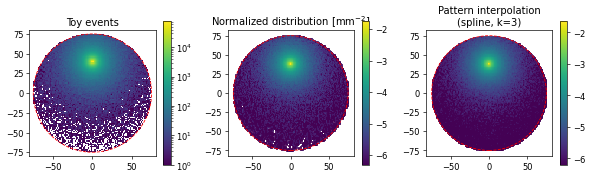

In [28]:
plot_pattern_reconstruction(toy_events, x_bin_middles,y_bin_middles,hist_density,pattern)

In [29]:
print('Wooray!')

Wooray!


## Getting a pattern for each hex center

The following lines can be used to make the patterns for all the hex centers. This method is deprecated as a script where the creation of patterns is paralelised was written. Find it in [XenoDiffusionScope/scripts/make_patterns.py](https://github.com/ricmperes/XenoDiffusionScope/blob/4599fc5e97ce90fa9afd1d99f40fd4debc8a1258/scripts/make_patterns.py)! Run `python make_patterns.py --help` to see available options.